### Imports

In [1]:
import tclab
from tclab import Plotter, clock, Historian

import numpy as np
import tbcontrol
from tbcontrol import blocksim

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%matplotlib inline

### Defining functions and blocksim blocks

In [3]:
def controller_block(controller_type, parameters):
    
    if controller_type == 'P':
        Kc_P = parameters
        Gc_P = blocksim.LTI('Gc_P', 'e', 'Q', Kc_P, 1)
        return Gc_P
    
    if controller_type == 'PI':
        Kc_PI, τI_PI = parameters
        Gc_PI = blocksim.PI('Gc_PI','e','Q', Kc_PI, τI_PI)
        return Gc_PI
    
    if controller_type == 'PD':
        Kc_PD, τD_PD, α = parameters
        Gc_PD = blocksim.LTI('Gc_PD','e','Q', [Kc_PD * τD_PD * (α + 1), Kc_PD], [τD_PD * α, 1]) 
        # Used the α term for physical realizability - Textbook eq 7-12 pg 129
        return Gc_PD
    
    if controller_type == 'PID':
        Kc_PID, τI_PID, τD_PID = parameters
        Gc_PID = blocksim.PID('Gc_PID', 'e', 'Q', Kc_PID, τI_PID, τD_PID)
        return Gc_PID

In [4]:
def system_block(Kp, τp, θp):
    Gp = blocksim.LTI('Gp', 'Q', 'Tp', Kp, [τp, 1], θp) # Block of the system FOPDT model
    return Gp

- The following cell contains the blocks that can be used as 'controller_block' inputs to the 'diagram' function.
- The parameters need to be changed to the correct FOPDT + Cohen-Coon parameters

In [5]:
Gp = system_block(0.6, 147, 13) # parameters = Kp, τp, θp

Gc_P = controller_block('P', [19]) # parameters = Kc_P

Gc_PI = controller_block('PI', [16, 48]) # parameters = Kc_PI, τI_PI

Gc_PD = controller_block('PD', [20, 5, 1]) # parameters = Kc_PD, τD_PD, α

Gc_PID = controller_block('PID', [24, 43, 6]) # parameters = Kc_PID, τI_PID, τD_PID

In [6]:
def diagram(controller_block ,system_block, setpoint_starttime, disturbance_starttime):
    Gc = controller_block
    Gp = system_block
    
    diagram = blocksim.Diagram([Gc, Gp],
                            sums = {'e': ('+Tsp', '-T'), 'T': ('+Td', '+Tp')},
                               # The disturbance will be added here also when we get there
                            inputs = {'Tsp': blocksim.step(starttime = setpoint_starttime),
                                      'Td': blocksim.step(starttime = disturbance_starttime)}
                            )
    return diagram

In [7]:
diagram_P = diagram(Gc_P, Gp, 100, 500) # Setpoint change at 100, Disturbance change at 500
diagram_PI = diagram(Gc_PI, Gp, 100, 500)
diagram_PD = diagram(Gc_PD, Gp, 100, 500)
diagram_PID = diagram(Gc_PID, Gp, 100, 500)

### Simulation with models

In [8]:
ts = np.linspace(0, 1000, 5000)

In [9]:
simulation_P = diagram_P.simulate(ts, progress = True)
simulation_PI = diagram_PI.simulate(ts, progress = True)
simulation_PD = diagram_PD.simulate(ts, progress = True)
simulation_PID = diagram_PID.simulate(ts, progress = True)

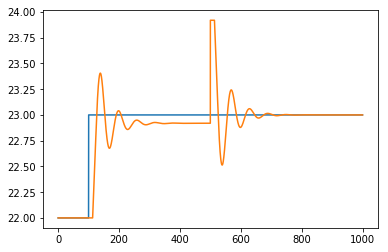

In [10]:
plt.figure(1)
plt.plot(list(ts), [T+22 for T in simulation_P['Tsp']])
plt.plot(list(ts), [T+22 for T in simulation_P['T']])
plt.show()

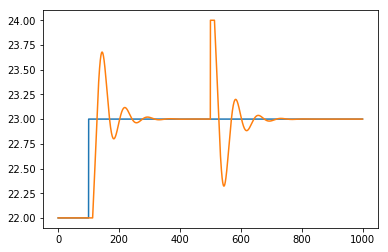

In [11]:
plt.figure(2)
plt.plot(list(ts), [T+22 for T in simulation_PI['Tsp']])
plt.plot(list(ts), [T+22 for T in simulation_PI['T']])
plt.show()

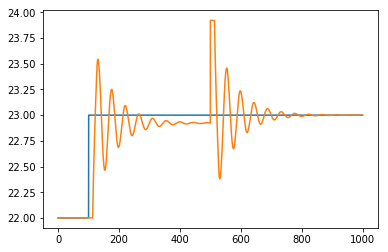

In [12]:
plt.figure(3)
plt.plot(list(ts), [T+22 for T in simulation_PD['Tsp']])
plt.plot(list(ts), [T+22 for T in simulation_PD['T']])
plt.show()

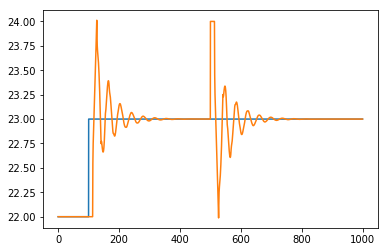

In [13]:
plt.figure(4)
plt.plot(list(ts), [T+22 for T in simulation_PID['Tsp']])
plt.plot(list(ts), [T+22 for T in simulation_PID['T']])
plt.show()

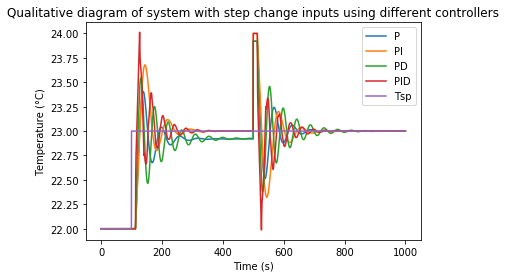

In [14]:
plt.figure(5)
plt.plot(list(ts), [T+22 for T in simulation_P['T']], label='P')
plt.plot(list(ts), [T+22 for T in simulation_PI['T']], label ='PI')
plt.plot(list(ts), [T+22 for T in simulation_PD['T']], label ='PD')
plt.plot(list(ts), [T+22 for T in simulation_PID['T']], label ='PID')
plt.plot(list(ts), [T+22 for T in simulation_PID['Tsp']], label ='Tsp')
plt.title("Qualitative diagram of system with step change inputs using different controllers")
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

### Running controllers with the TCLab

##### PID

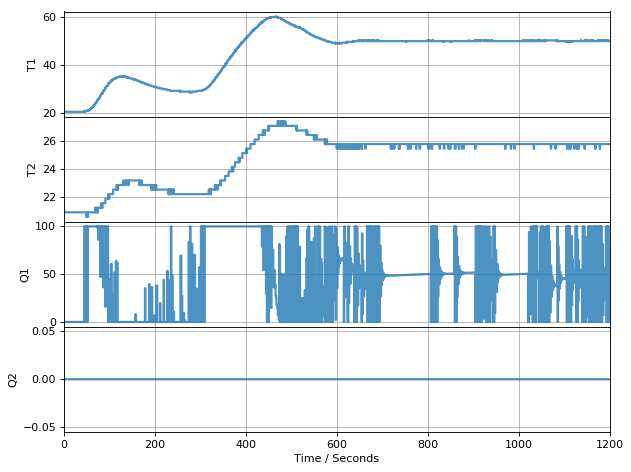

TCLab Model disconnected successfully.


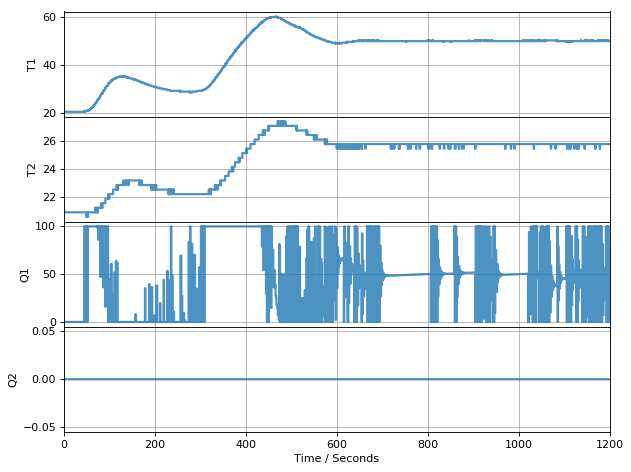

In [15]:
TCLab = tclab.setup(connected=False, speedup=100)

# Gc_PID = controller_block('PID', [24, 43, 6]) 
# This is already defined above

with TCLab() as lab:
    h = tclab.Historian(lab.sources)
    p = Plotter(h, 1200)
    
    for t in clock(1200):
        if t < 300:
            T1sp = 30
        else:
            T1sp = 50
        
        Q1 = lab.Q1(Gc_PID.output)
        T1 = lab.T1
        e = T1sp - T1
        Gc_PID.change_input(t, e)
        Gc_PID.change_state(Gc_PID.state + Gc_PID.derivative(e))
        
        
        h.update(t) 
        p.update(t)

##### PI

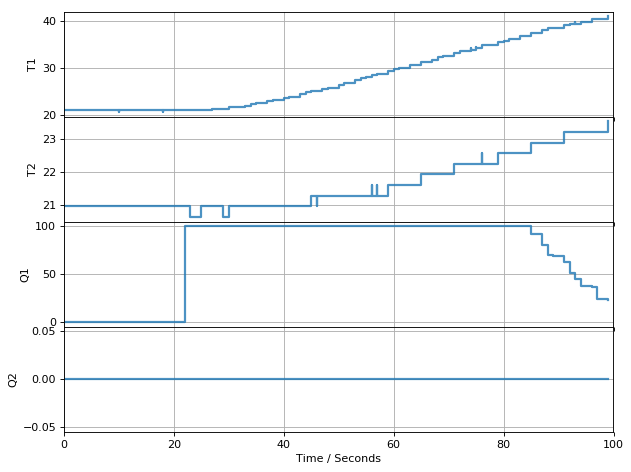

TCLab Model disconnected successfully.


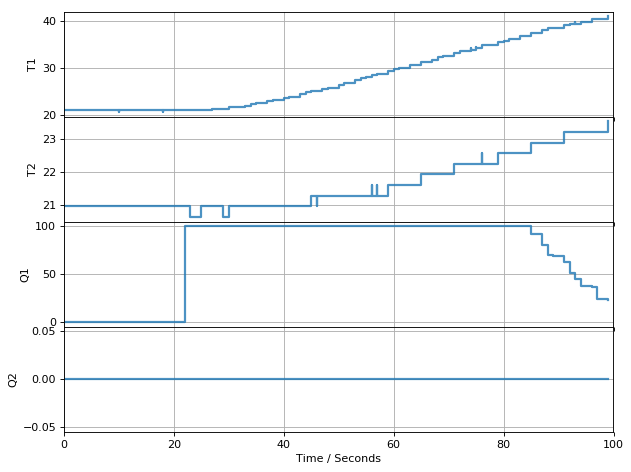

In [16]:
TCLab = tclab.setup(connected=False, speedup=10)

# Gc_PI = controller_block('PI', [16, 48]) # parameters = Kc_PI, τI_PI
# This is already defined above

with TCLab() as lab:
    h = tclab.Historian(lab.sources)
    p=Plotter(h, 100)
    
    for t in clock(100):
        if t < 20:
            T1sp = 20
        else:
            T1sp = 35
        Q1 = lab.Q1(Gc_PI.output)
        T1 = lab.T1
        e = T1sp-T1
        Gc_PI.change_input(t,e)
        Gc_PI.change_state(Gc_PI.state+Gc_PI.derivative(e))
        
        
        h.update(t) 
        p.update(t)

##### P

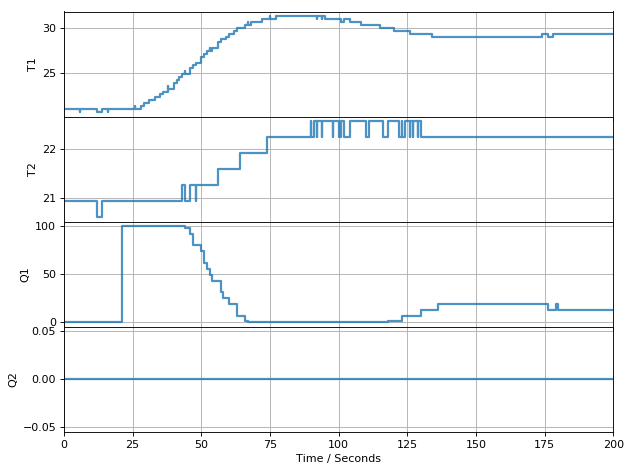

TCLab Model disconnected successfully.


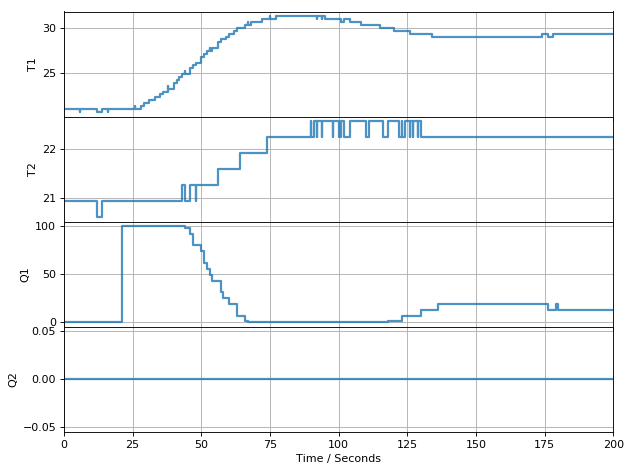

In [17]:
TCLab = tclab.setup(connected=False, speedup=10)

# Gc_P = controller_block('P', [19]) # parameters = Kc_P
# This is already defined above

with TCLab() as lab:
    h = tclab.Historian(lab.sources)
    p=Plotter(h, 200)
    
    for t in clock(200):
        if t < 20:
            T1sp = 20
        else:
            T1sp = 30
        Q1 = lab.Q1(Gc_P.output)
        T1 = lab.T1
        e = T1sp-T1
        Gc_P.change_input(t,e)
        Gc_P.change_state(Gc_P.state + Gc_P.derivative(e))
        
        
        h.update(t) 
        p.update(t)

##### PD

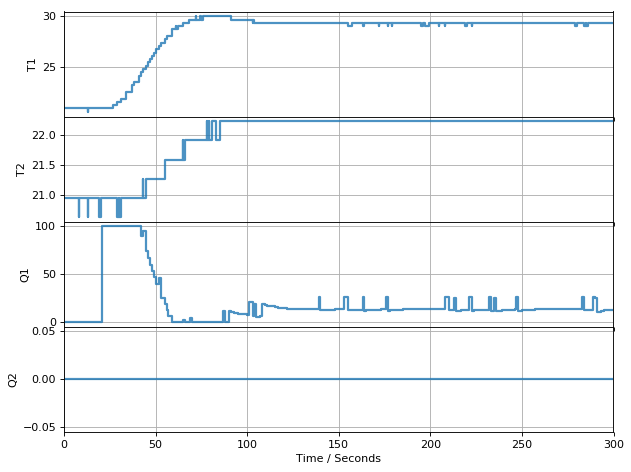

TCLab Model disconnected successfully.


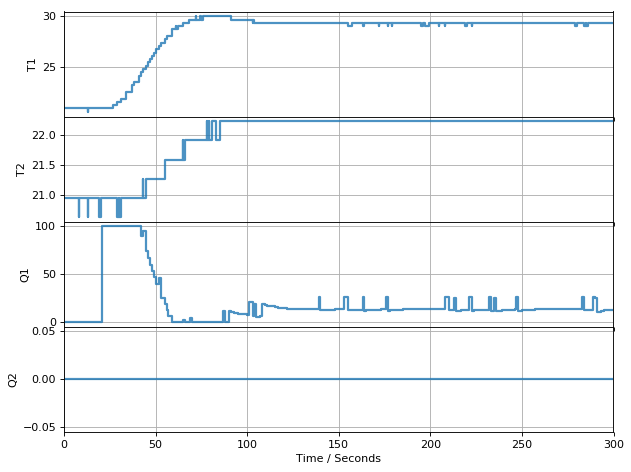

In [18]:
TCLab = tclab.setup(connected=False, speedup=10)

# Gc_PD = controller_block('PD', [20, 5, 1]) # parameters = Kc_PD, τD_PD, α
# This is already defined above

with TCLab() as lab:
    h = tclab.Historian(lab.sources)
    p=Plotter(h, 300)
    
    for t in clock(300):
        if t < 20:
            T1sp = 20
        else:
            T1sp = 30
        Q1 = lab.Q1(Gc_PD.output)
        T1 = lab.T1
        e = T1sp- T1
        Gc_PD.change_input(t, e)
        Gc_PD.change_state(Gc_PD.state + Gc_PD.derivative(e))
        
        
        h.update(t) 
        p.update(t)

#### Set point changes

#### Disturbance changes